Short notebook that attmempts to identify possible trivial crossings by tracking the wavefunction of the active P.E.S each timestep, where a trivial crossing (leading to exciton dissociation) is likely when the XT-character of the wavefunction becomes miniscule when it was dominant in the previous timestep.

In [1]:
import numpy as np
import numpy.ma as nm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys

sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
import XSH_eigenstates_Filip as XSF

In [2]:
def find_dissociation_index(iterable, population_threshold, post_dissoc_elements, post_dissoc_buffer):
    #short function to idensity xt-dissoc from the surface wf populations: first index where XT-character is below population_threshold, and remains 
    #below theshold + buffer (real 0<x<1) for all post_dissoc_elements (int)

    for outer_index in range(len(iterable)):

        if iterable[outer_index] < population_threshold:

            for inner_val in iterable[outer_index: outer_index + post_dissoc_elements]:

                if inner_val > population_threshold + post_dissoc_buffer:
                    
                    fluctuation = True
                    break

                else:
                    fluctuation = False

            if not fluctuation:

                return outer_index
            
    return None

In [3]:
def dissociation_speed(iterable, dissociation_index, population_theshold):
    #how long dissociation process takes

    truncated_interable = iterable[:dissociation_index]

    XT_indices = np.where(truncated_interable > population_theshold)[0]
    if np.any(XT_indices):
        dissociation_start_point = np.max(XT_indices)
    else:
        return None

    return (dissociation_index - dissociation_start_point)

In [4]:
file_marker = 'e5_3xCT_0.01fs'
analysis_path = f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/energy_landscape/{file_marker}_t_dependent_eigens'
nuclear_timestep = 0.01

simulation = 'epsilon5_3xCTcoup'

In [5]:
#loading in different electronic components of the total normalised electronic population

total_XT_single_populations = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{simulation}/analysis_arrays/{file_marker}_XT_individual_swf.txt')
CSS_single_populations = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{simulation}/analysis_arrays/{file_marker}_CSS_individual_swf.txt')
INT_single_populations = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{simulation}/analysis_arrays/{file_marker}_INT_individual_swf.txt')

XT_single_locations = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{simulation}/analysis_arrays/{file_marker}_individual_exciton_locations_swf.txt')

In [6]:
#this block of code uses the above functions to identify substantial xt-dissociation events and track each population for their duration

dissoc_times = []
dissoc_distances = []

dissoc_array_length = 800

#assigning population arrays
dissoc_exciton_pop_array = np.zeros((len(total_XT_single_populations), dissoc_array_length))
dissoc_CSS_pop_array = np.zeros((len(total_XT_single_populations), dissoc_array_length))
dissoc_INT_pop_array = np.zeros((len(total_XT_single_populations), dissoc_array_length))


for index in range(len(total_XT_single_populations)):

    shading_parameter = 1 - index/len(total_XT_single_populations)

    #index where dissociation begins, if at all
    XT_dissociation_index = find_dissociation_index(total_XT_single_populations[index], 0.05, 5000, 0.05)

    if XT_dissociation_index:

        #how many timesteps it takes to cross threshold of 0.05
        dissociation_length = dissociation_speed(total_XT_single_populations[index], XT_dissociation_index, 0.95)

        if dissociation_length:

            dissociation_window = total_XT_single_populations[index][XT_dissociation_index - dissociation_length : XT_dissociation_index + 1]
            dissociation_exciton_locs = XT_single_locations[index][XT_dissociation_index - dissociation_length : XT_dissociation_index + 1]

            #taking slices of each population type over the dissociation time frame, passing them into the arrays
            dissociation_exciton_pop = total_XT_single_populations[index][XT_dissociation_index - dissociation_length : XT_dissociation_index - dissociation_length + dissoc_array_length]
            dissoc_exciton_pop_array[index, :len(dissociation_exciton_pop)] = dissociation_exciton_pop

            dissociation_CSS_pop = CSS_single_populations[index][XT_dissociation_index - dissociation_length : XT_dissociation_index - dissociation_length + dissoc_array_length]
            dissoc_CSS_pop_array[index, :len(dissociation_CSS_pop)] = dissociation_CSS_pop

            dissociation_INT_pop = INT_single_populations[index][XT_dissociation_index - dissociation_length : XT_dissociation_index - dissociation_length + dissoc_array_length]
            dissoc_INT_pop_array[index, :len(dissociation_INT_pop)] = dissociation_INT_pop

            dissoc_times.append(dissociation_length*nuclear_timestep)
            dissoc_distances.append(dissociation_exciton_locs[0]-92)

            #plt.plot(np.arange(len(dissociation_window))*nuclear_timestep, dissociation_window, color = 'b', linewidth = 0.4)
            #plt.scatter(np.arange(len(dissociation_window))[-1]*nuclear_timestep, -0.05, color = 'r', s = 10)

#plt.ylabel('XT character')
#plt.xlabel('Dissociation time /fs')

#plt.xlabel('Simulation time /fs')
#plt.ylabel('XT population')
#plt.legend()

#getting non-interfacial CT populations during exciton dissociation
dissoc_CT_pop_array = 1 - dissoc_exciton_pop_array - dissoc_INT_pop_array - dissoc_CSS_pop_array

(0.0, 100.0)

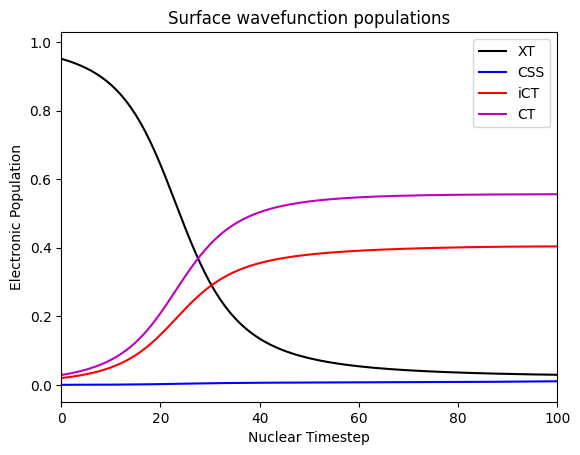

In [7]:
time_axis = np.arange(len(dissoc_CSS_pop_array[0]))
traj = 409

plt.plot(time_axis, dissoc_exciton_pop_array[traj], color='k', label='XT')
plt.plot(time_axis, dissoc_CSS_pop_array[traj], color='b', label='CSS')
plt.plot(time_axis, dissoc_INT_pop_array[traj], color='r', label='iCT')
plt.plot(time_axis, dissoc_CT_pop_array[traj], color='m', label='CT')
plt.legend()
plt.title('Surface wavefunction populations')

plt.xlabel('Nuclear Timestep')
plt.ylabel('Electronic Population')
plt.xlim([0,100])

(-2.0, 50.0)

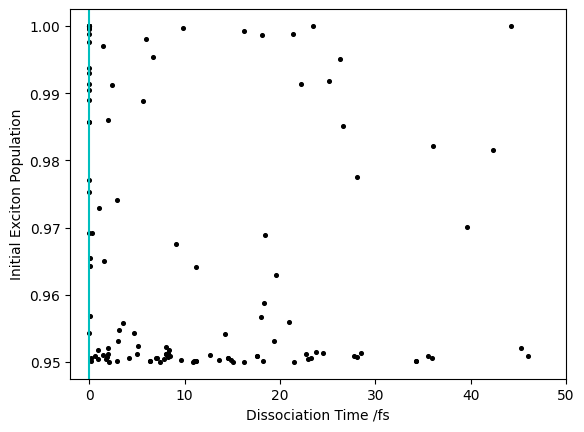

In [13]:
non_zero_indices = np.where(dissoc_exciton_pop_array[:,0] > 0)[0]

plt.scatter(dissoc_times, dissoc_exciton_pop_array[non_zero_indices,0], color='k', s=7)
plt.axvline(0, color='c')
plt.ylabel('Initial Exciton Population')
plt.xlabel('Dissociation Time /fs')
plt.xlim([-2,50])

Text(0, 0.5, 'Dissociation Time /fs')

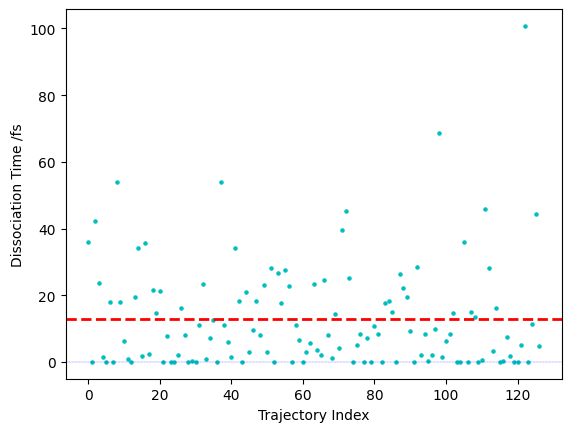

In [9]:
plt.axhline(np.mean(dissoc_times), color='r', linestyle='--', linewidth=2)
plt.axhline(0, linestyle='--', linewidth=0.2, color='b')
plt.scatter(np.arange(len(dissoc_times)), dissoc_times, color = 'c', s=5)

plt.xlabel('Trajectory Index')
plt.ylabel('Dissociation Time /fs')

Text(0, 0.5, 'Exciton Dissociation Distance /Å')

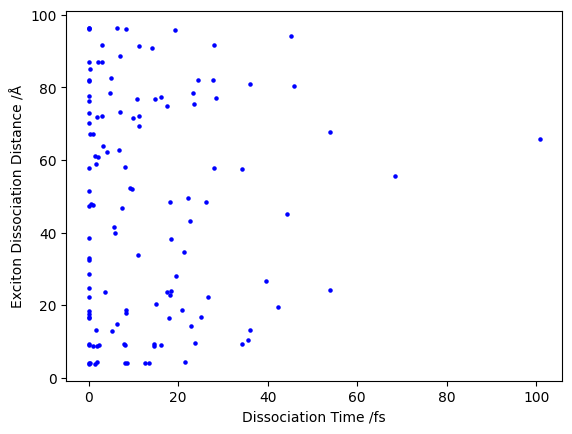

In [10]:
plt.scatter(dissoc_times, dissoc_distances, color='b', s=5)
plt.xlabel('Dissociation Time /fs')
plt.ylabel('Exciton Dissociation Distance /\u212B')